In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage.measurements import center_of_mass
from functools import reduce
import operator
import math

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.sqlcontroller import SqlController

In [71]:

def sort_from_center(polygon):
    '''
    Get the center of the polygon and then use atan2 to get
    the angle from the x-axis to the x,y point. Use that to sort.
    :param polygon:
    '''
    center = tuple(map(operator.truediv, reduce(lambda x, y: map(operator.add, x, y), polygon), [len(polygon)] * 2))
    return sorted(polygon, key=lambda coord: (math.atan2(*tuple(map(operator.sub, coord, center))[::-1]))), center

def sort_from_center_np(polygon):
    coords = np.array(polygon)
    center = coords.mean(axis=0)
    centered = coords - center
    angles = -np.arctan2(centered[:,1], centered[:,0])
    sorted_coords = coords[np.argsort(angles)]
    return list(map(tuple, sorted_coords)), center

def interpolate2d(points, new_len):
    '''
    Interpolates a list of tuples to the specified length. The points param
    must be a list of tuples in 2d
    :param points: list of floats
    :param new_len: integer you want to interpolate to. This will be the new
    length of the array
    There can't be any consecutive identical points or an error will be thrown
    unique_rows = np.unique(original_array, axis=0)
    '''
    points = np.array(points)
    lastcolumn = np.round(points[:,-1])
    z = mode(lastcolumn)
    points2d = np.delete(points, -1, axis=1)
    pu = points2d.astype(int)
    indexes = np.unique(pu, axis=0, return_index=True)[1]
    points = np.array([points2d[index] for index in sorted(indexes)])
    addme = points2d[0].reshape(1, 2)
    points2d = np.concatenate((points2d, addme), axis=0)

    tck, u = splprep(points2d.T, u=None, s=3, per=1)
    u_new = np.linspace(u.min(), u.max(), new_len)
    x_array, y_array = splev(u_new, tck, der=0)
    arr_2d = np.concatenate([x_array[:, None], y_array[:, None]], axis=1)
    arr_3d = np.c_[ arr_2d, np.zeros(new_len)+z ] 
    return list(map(tuple, arr_3d))


In [4]:
polygon = [(37755.692307692305, 10026.276923076923, 236), (36032.92307692308, 14735.692307692309, 236), (36109.53846153846, 16994.676923076924, 236), (42273.84615384615, 19253.661538461536, 236), (45260.307692307695, 19483.384615384617, 236), (45375.07692307692, 16726.64615384615, 236), (43881.846153846156, 12974.430769230768, 236), (40678.153846153844, 9906.984615384616, 236)]

In [72]:
sorted_points1, center1 = sort_from_center(polygon)
sorted_points2, center2 = sort_from_center_np(polygon)

In [73]:
print(sorted_points1)

[(36032.92307692308, 14735.692307692309, 236), (37755.692307692305, 10026.276923076923, 236), (40678.153846153844, 9906.984615384616, 236), (43881.846153846156, 12974.430769230768, 236), (45375.07692307692, 16726.64615384615, 236), (45260.307692307695, 19483.384615384617, 236), (42273.84615384615, 19253.661538461536, 236), (36109.53846153846, 16994.676923076924, 236)]


In [74]:
print(sorted_points2)

[(36109.53846153846, 16994.676923076924, 236.0), (42273.84615384615, 19253.661538461536, 236.0), (45260.307692307695, 19483.384615384617, 236.0), (45375.07692307692, 16726.64615384615, 236.0), (43881.846153846156, 12974.430769230768, 236.0), (40678.153846153844, 9906.984615384616, 236.0), (37755.692307692305, 10026.276923076923, 236.0), (36032.92307692308, 14735.692307692309, 236.0)]


In [16]:
xs = sorted_points[:,0]
ys = sorted_points[:,1]
xus = unsorted_points[:,0]
yus = unsorted_points[:,1]

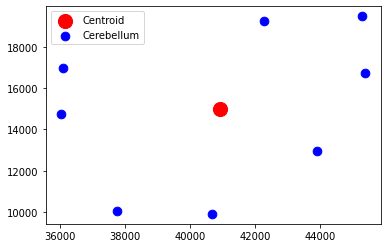

In [37]:
plt.scatter(x=center[0], y=center[1], s=200, c='r', label='Centroid')  # use this to plot a single point
plt.scatter(x=xs, y=ys, c='b', s=75, label='Cerebellum')
plt.legend()
plt.show()

In [45]:
print(x)
print()
print(y)

[37755.692307692305, 36032.92307692308, 36109.53846153846, 42273.84615384615, 45260.307692307695, 45375.07692307692, 43881.846153846156, 40678.153846153844]

[10026.276923076923, 14735.692307692309, 16994.676923076924, 19253.661538461536, 19483.384615384617, 16726.64615384615, 12974.430769230768, 9906.984615384616]


In [62]:
X = xs.tolist()
Y = ys.tolist()

for x,y in zip(X,Y):
    y0 = center[1]
    x0 = center[0]
    
    angle_degrees = math.degrees(math.atan2(y0 - y, x0 - x)) % 360
    angle_radians = math.atan2(y0 - y, x0 - x)
    print(x,y,angle_degrees, angle_radians)

36032.92307692308 14735.692307692309 3.2437626466353495 0.05661433833699221
37755.692307692305 10026.276923076923 57.59395312127523 1.0052041112055177
40678.153846153844 9906.984615384616 87.27773081852074 1.5232837664525125
43881.846153846156 12974.430769230768 145.45662016299488 2.5386969406670317
45375.07692307692 16726.64615384615 201.04637235346237 -2.774264160421167
45260.307692307695 19483.384615384617 225.85371562568054 -2.341294341648496
42273.84615384615 19253.661538461536 252.3065509706101 -1.8796052683915452
36109.53846153846 16994.676923076924 337.61172672358435 -0.39074908250971196
